In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album


In [2]:
%pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp



Note: you may need to restart the kernel to use updated packages.


In [3]:
class DiceLoss(torch.nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()
	
	def forward(self, pred, target):
		smooth = 1.0
		iflat = pred.contiguous().view(-1)
		tflat = target.contiguous().view(-1)
		intersection = (iflat * tflat).sum()
		A_sum = iflat.sum()
		B_sum - tflat.sum()

		return 1 - ((2.0 * intersection + smooth) / (A_sum + B_sum + smooth))


In [4]:
class IoU(torch.nn.Module):
	def __init__(self, threshold=0.5):
		super(IoU, self).__init__()
		self.threshold = threshold
	
	def forward(self, preds, targets):
		preds = (preds > self.threshold).float()
		intersection = (preds * targets).sum()
		union = preds.sum() + targets.sum() - intersection

		return (intersection / union).item() if union > 0 else 0.0


In [5]:
DATA_DIR = './massachusetts-buildings-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')


In [6]:
class_dict = pd.read_csv("./massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [8]:
def visualize(**images):
	n_images = len(images)
	plt.figure(figsize=(20, 8))

	for idx, (name, image) in enumerate(images.items()):
		plt.subplot(1, n_images, idx+1)
		plt.xticks([])
		plt.yticks([])
		plt.title(name.replace('_', ' ').title(), fontsize=20)
		plt.imshow(image)
	plt.show()

def one_hot_encode(label, label_values):
	semantic_map = []
	for colour in label_values:
		equality = np.equal(label, colour)
		class_map = np.all(equality, axis= -1)
		semantic_map.append(class_map)
	semantic_map = np.stack(semantic_map, axis= -1)

	return semantic_map

def reverse_one_hot(image):
	x = np.argmax(image, axis= -1)
	return x

def colour_code_segmentation(image, label_values):
	colour_codes = np.array(label_values)
	x = colour_codes[image.astype(int)]

	return x


In [9]:
class BuildingsDataset(torch.utils.data.Dataset):
	def __init__(self, images_dir, masks_dir, class_rgb_values=None, augmentation=None, preprocessing=None):
		self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
		self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

		self.class_rgb_values = class_rgb_values
		self.augmentation = augmentation
		self.preprocessing = preprocessing
	
	def __getitem__(self, i):
		image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
		mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

		# mask에 one-hot-encode 적용
		mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

		if self.augmentation:
			sample = self.augmentation(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']

		if self.preprocessing:
			sample = self.preprocessing(image=image, mask=mask)  # 'image='과 'mask=' 명시
			image, mask = sample['image'], sample['mask']
		
		return image, mask
	
	def __len__(self):
		return len(self.image_paths)


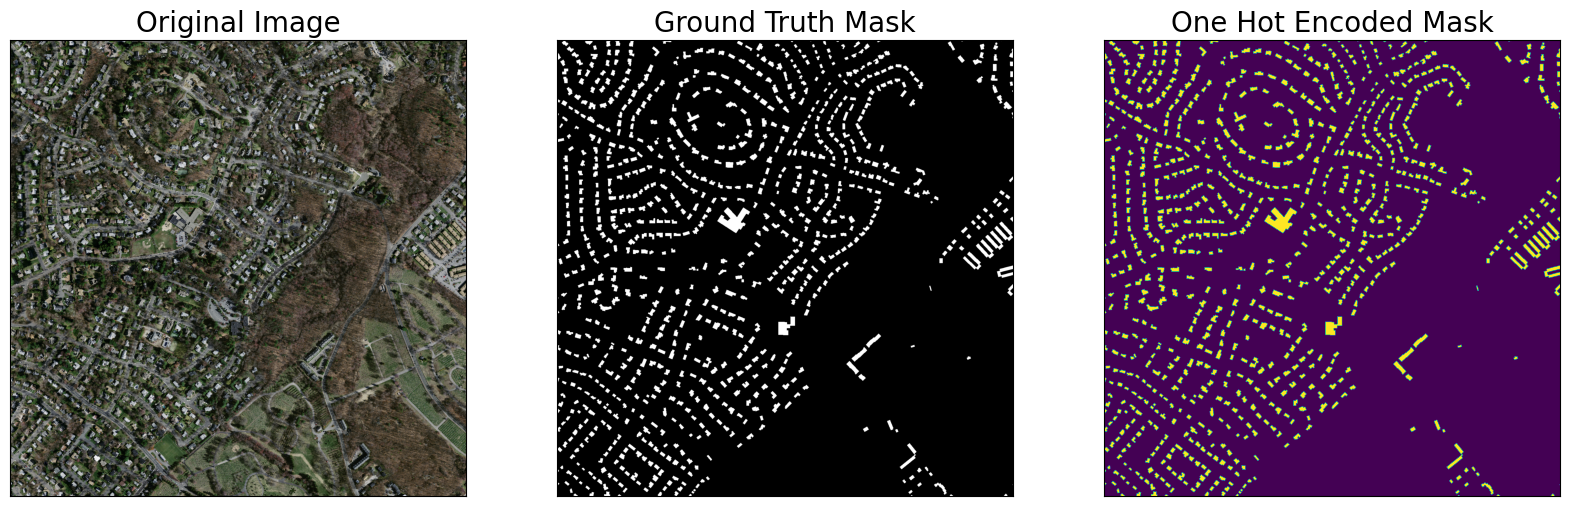

In [10]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
	original_image = image, ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values), one_hot_encoded_mask = reverse_one_hot(mask)
)


In [11]:
def get_training_augmentation():
	train_transform = [
		album.RandomCrop(height=256, width=256, always_apply=True),
		album.OneOf(
			[
				album.HorizontalFlip(p=1),
				album.VerticalFlip(p=1),
				album.RandomRotate90(p=1),
			],
			p=0.75,
		),
	]
	return album.Compose(train_transform)

def get_validation_augmentation():
	test_transform = [
		album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
	]
	return album.Compose(test_transform)

def to_tensor(x, **kwargs):
	return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
	_transform = []
	if preprocessing_fn:
		_transform.append(album.Lambda(image=preprocessing_fn))
	_transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

	return album.Compose(_transform)


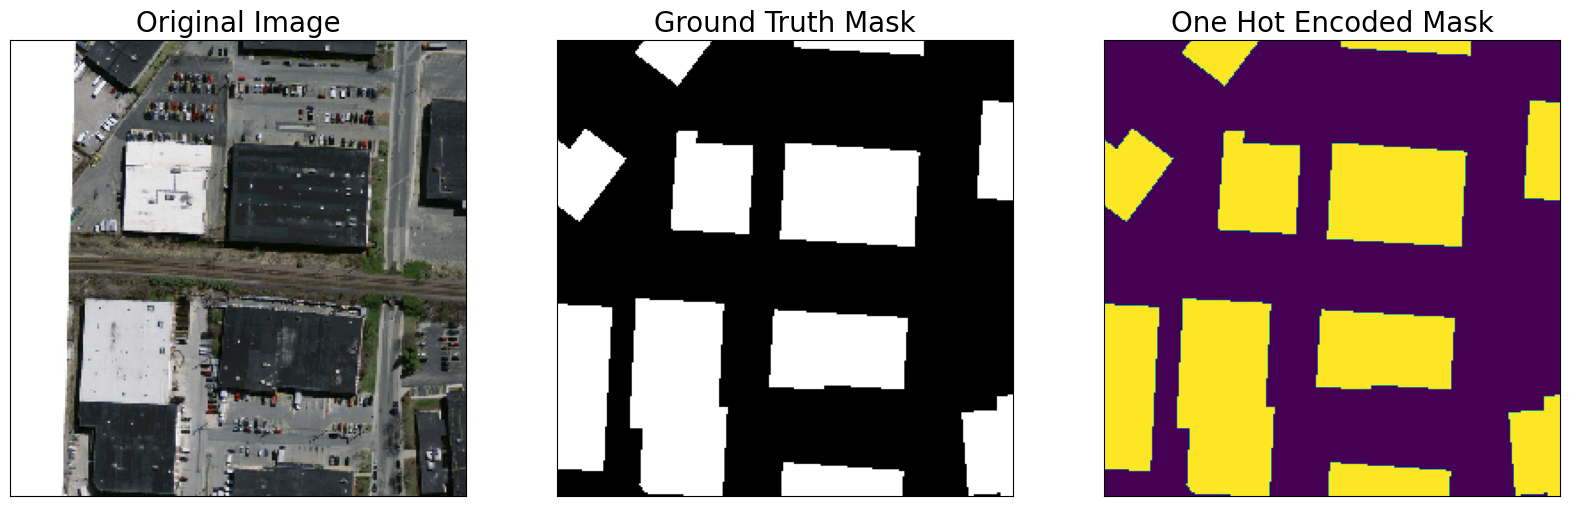

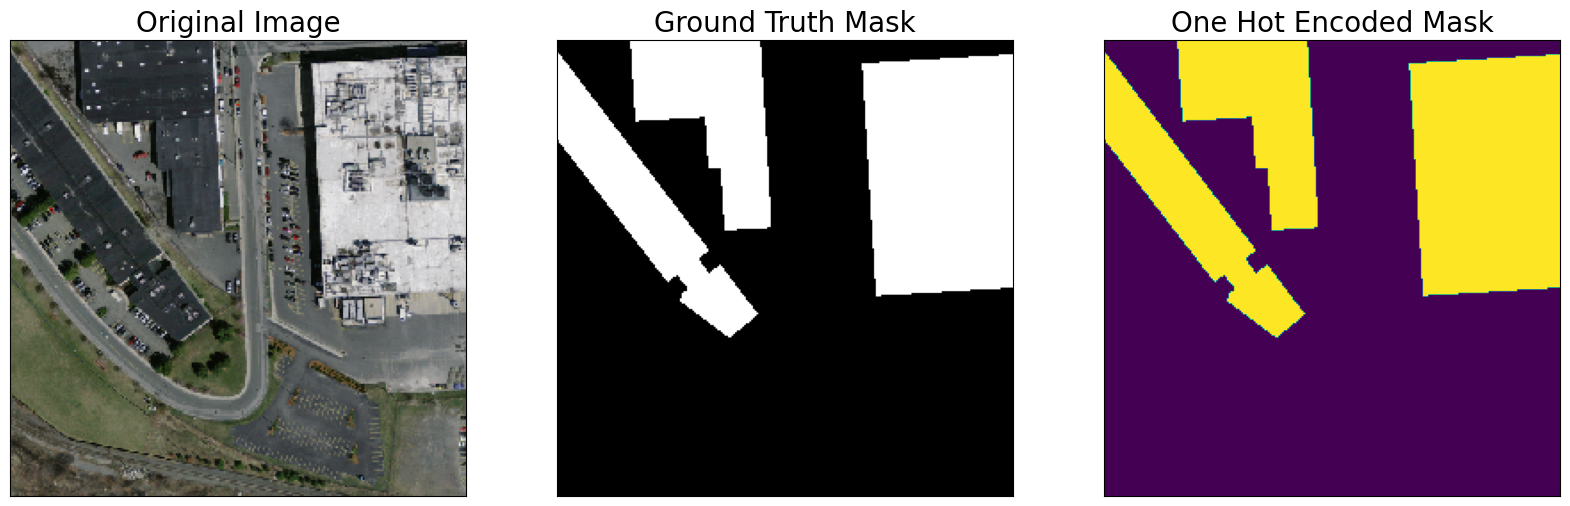

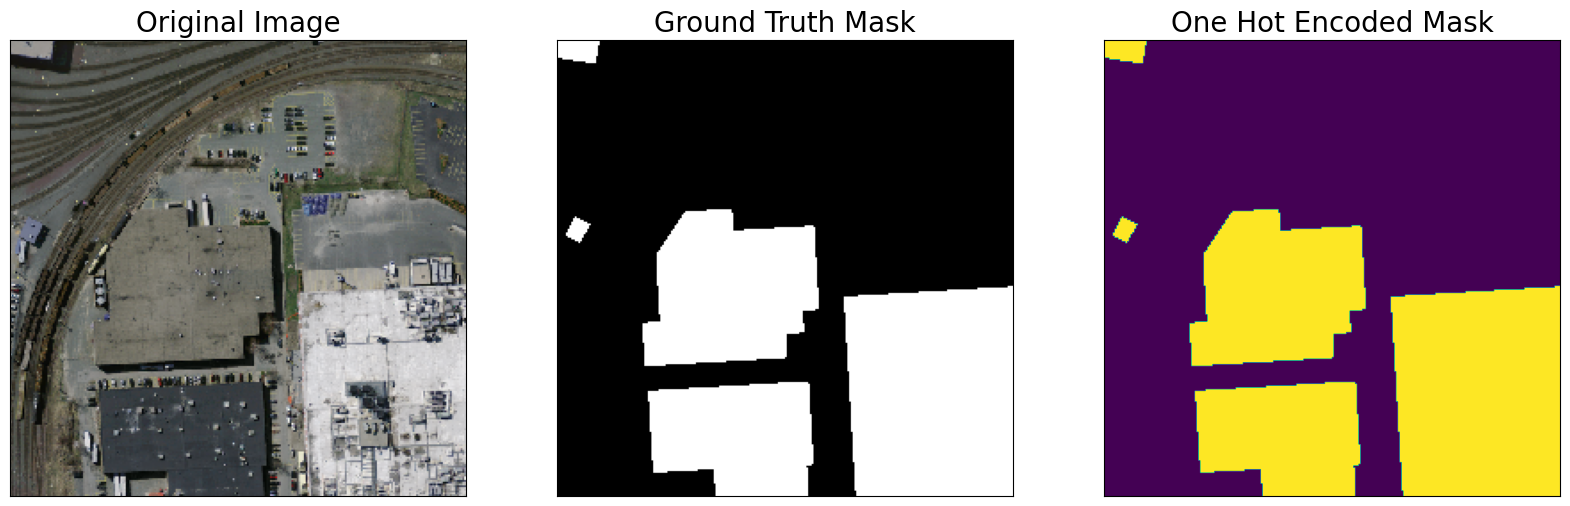

In [12]:
augmented_dataset = BuildingsDataset(
	x_train_dir, y_train_dir, augmentation=get_training_augmentation(),
	class_rgb_values = select_class_rgb_values)

random_idx = random.randint(0, len(augmented_dataset)-1)

for i in range(3):
	image, mask = augmented_dataset[random_idx]
	visualize(
		original_image = image,
		ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
		one_hot_encoded_mask = reverse_one_hot(mask)
	)


In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet()


In [14]:
train_dataset = BuildingsDataset(
	x_train_dir, y_train_dir, 
	augmentation=get_training_augmentation(),
	preprocessing=get_preprocessing(preprocessing_fn=None),
	class_rgb_values = select_class_rgb_values
)

valid_dataset = BuildingsDataset(
	x_train_dir, y_train_dir, 
	augmentation=get_validation_augmentation(),
	preprocessing=get_preprocessing(preprocessing_fn=None),
	class_rgb_values = select_class_rgb_values
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [15]:
from torchmetrics import Accuracy


In [16]:
training=True

epochs=12

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

loss = DiceLoss()

metrics = IoU(threshold=0.5)


optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.00008) ])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
	optimizer, T_0=1, T_mult=2, eta_min=5e-5
)

if os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
	model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth',
	map_location=device)


In [17]:
class TrainEpoch:
    def __init__(self, model, loss_fn, metrics, optimizer, device):
        self.model = model
        self.loss_fn = loss_fn
        self.metrics = metrics
        self.optimizer = optimizer
        self.device = device

    def run(self, data_loader):
        self.model.train()
        epoch_loss = 0.0
        epoch_metrics = {type(metric).__name__: 0.0 for metric in self.metrics}

        for images, masks in data_loader:
            images, masks = images.to(self.device), masks.to(self.device)

            # Forward pass
            outputs = self.model(images)
            loss = self.loss_fn(outputs, masks)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            for metric in self.metrics:
                epoch_metrics[type(metric).__name__] += metric(outputs, masks).item()

        # Average metrics
        epoch_loss /= len(data_loader)
        for key in epoch_metrics:
            epoch_metrics[key] /= len(data_loader)

        return {"loss": epoch_loss, **epoch_metrics}


class ValidEpoch:
    def __init__(self, model, loss_fn, metrics, device):
        self.model = model
        self.loss_fn = loss_fn
        self.metrics = metrics
        self.device = device

    def run(self, data_loader):
        self.model.eval()
        epoch_loss = 0.0
        epoch_metrics = {type(metric).__name__: 0.0 for metric in self.metrics}

        with torch.no_grad():
            for images, masks in data_loader:
                images, masks = images.to(self.device), masks.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.loss_fn(outputs, masks)

                # Update metrics
                epoch_loss += loss.item()
                for metric in self.metrics:
                    epoch_metrics[type(metric).__name__] += metric(outputs, masks).item()

        # Average metrics
        epoch_loss /= len(data_loader)
        for key in epoch_metrics:
            epoch_metrics[key] /= len(data_loader)

        return {"loss": epoch_loss, **epoch_metrics}

# _ = None


In [18]:
train_epoch = TrainEpoch(
    model=model,
    loss_fn=loss,
    metrics=[Accuracy(task="multiclass", num_classes=6)],
    optimizer=optimizer,
    device=device,
)

valid_epoch = ValidEpoch(
    model=model,
    loss_fn=loss,
    metrics=[Accuracy(task="multiclass", num_classes=6)],
    device=device,
)


In [19]:
if training:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, epochs):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')



Epoch: 0


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same